# 1. Introduction
In this notebook, we build a multi-linear regression model to characterize linear relations between sea surface temperature (SST) and several climate variables over different regions in Antarctica.

*Note: Due to limited rendering in GitHub .md file, **please visit the external view with jupyter nbviewer** (Click on the upper right button)*
## 1.1 Brief mathematical background
We define a "Green's function" to describe atmospheric response to anomalous SST fields by assuming that the mean state of atmospheric response to anomalous SST forcing can be approximated as a linear process.

The Green’s function, $K(x, x')$, that represents seasonal anomalous climate response $R(x)$ to anomalous SST ($T(x')$) at location $x'$ can be represented as follows:
\begin{equation*}
R(x) = \int_{A'}K(x,x')T(x')dA'+\varepsilon(x)
\end{equation*}

where $dA'$ indicates the area integral over the spatial field $x'$ and residual $\varepsilon(x)$ denotes nonlinearities, which could ot be captured by the linear relation. 

The equation can also be rewritten in discretized form as follows:
\begin{equation*}
R_{j} =\sum_{k}K_{jk}T_{k}A_{k}+\varepsilon_{j}
\end{equation*}

Here $K_{jk}$ is the matrix form of the Green's function of climate response at region $j$ to anomalous SST at ocean grid $k$. In this project, we estimate $K_{jk}$, which is called "**global teleconnection operator (GTO)**", to characterize linear relation between 6 climate variables over Antarctica and SST. 

## 1.2 Applications of GTO
GTO can easily be generalized and applied to detect the sensitivity of various climate variables to SST changes. So it is a very useful tool!

Our research group has applied GTO to address various aspects of regional climate changes based on SST, for example: 
* Regional climate over several regions, such as Eastern North America, East Africa, and Southeast Asia [[Li et al., (2012)](http://onlinelibrary.wiley.com/doi/10.1029/2011JD017186/abstract)]
* Temperature, precipitation and drought index changes over several major river basins (i.e., Amazon, Mississippi etc.) [[Tsai et al., (2016)](https://link.springer.com/article/10.1007/s00382-014-2449-1)]
* Several climate indices, such as NAO, PNA [[Li and Forest (2014)](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-14-00231.1)]

In this notebook, we calculate the GTO of 6 climate variables over 5 regions over Antarctica:
* Climate variables:
  * 2m air temperature ($T_{2m}$)
  * temperature at 700mb level (T700)
  * sea-level pressure (Precip)
  * geopotential height at 500mb (H500)
  * geopotential height at 200mb (H200)
* Regions over Antarctica:
  * Whole Antarctica (61S-90S, 0-360)
  * East Antarctica  (66S-90S, 0-180&330-360)
  * West Antarctica  (65S-90S, 180-330)
  * Amundsen Sea Embayment (70S-80S, 230-260)
  * Antarctic Peninsula (61S-75S ,285-305)

For simplicity, we only plot GTO maps of 6 climate variables over the *Amundsen Sea Embayment (AMD)* for demo.

# 2. Experimental design and data
* Climate model used: NCAR Community Atmosphere Model (CAM)
* SST forcings
  * We randomly perturbed 1000 unique SST fields between 60S-60N based on climatological SST fields
* CAM control runs
  * Control run is ~110 years, the output from 10th-109th years are used as initial conditions recursively to branch the perturbed 1k-member ensemble
* CAM perturbed runs
  * We run 1k ensemble members forced by 1000 perturbed SST fields
  * Each ensemble member is run for 20 months, but only the output of last 12 month are used to construct GTO 

# 3. Script for calculating GTO
Here we provide a sample script and steps for calculating and plotting the GTO based on the NCAR CAM simulations (please click "**show code**" button on top left of this jupyter nbviewer page to see the code):

In [14]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as net4
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
from pylab import *
import matplotlib.backends.backend_pdf
import statsmodels
import statsmodels.api as sm

import scipy
from scipy import stats
from scipy.stats import pearsonr

import Ngl
import Nio
import os
import sys

np.set_printoptions(threshold='nan',precision=3)

In [2]:
# Define a function for calculating seasonal mean
def month_to_season(data,seasonN):
    nyr = data.shape[0]/12
    if nyr == 1:
        sea_mean = np.ma.masked_invalid(np.empty([data.shape[1],data.shape[2]])*np.nan)
        if seasonN == 'DJF':
            DDec = data[11,:,:]
            DJan = data[0,:,:]
            DFeb = data[1,:,:]
            sea_mean = (DDec*31.0 + DJan*31.0 + DFeb*28.0)/(31.0+31.0+28.0)
        elif seasonN == 'MAM':
            sea_mean = np.ma.average(data[2:5,:,:],axis=0,weights=[31.0/(31.0+30.0+31.0),30.0/(31.0+30.0+31.0),31.0/(31.0+30.0+31.0)])
        elif seasonN == 'JJA':
            sea_mean = np.ma.average(data[5:8,:,:],axis=0,weights=[30.0/(30.0+31.0+31.0),31.0/(30.0+31.0+31.0),31.0/(30.0+31.0+31.0)])
        else:           #SON
            sea_mean = np.ma.average(data[8:11,:,:],axis=0,weights=[30.0/(30.0+31.0+30.0),31.0/(30.0+31.0+30.0),30.0/(30.0+31.0+30.0)])

        return sea_mean

    else: # nyr > 1
        sea_mean = np.ma.masked_invalid(np.empty([nyr,data.shape[1],data.shape[2]])*np.nan)
        if seasonN == 'DJF':
            sea_mean[0,:,:] = np.ma.average(data[0:2,:,:],axis=0,weights=[31.0/(31.0+30.0),30.0/(31.0+30.0)]) # 1st year, use JF
            for yr in range(1,nyr):
                sea_mean[yr,:,:] = np.ma.average(data[(yr*12-1):(yr*12+2),:,:],axis=0,weights=[31.0/(31.0+31.0+28.0),31.0/(31.0+31.0+28.0),28.0/(31.0+31.0+28.0)])
        elif seasonN == 'MAM':
            for yr in range(nyr):
                sea_mean[yr,:,:] = np.ma.average(data[(yr*12+2):(yr*12+5),:,:],axis=0,weights=[31.0/(31.0+30.0+31.0),30.0/(31.0+30.0+31.0),31.0/(31.0+30.0+31.0)])
        elif seasonN == 'JJA':
            for yr in range(nyr):
                sea_mean[yr,:,:] = np.ma.average(data[(yr*12+5):(yr*12+8),:,:],axis=0,weights=[30.0/(30.0+31.0+31.0),31.0/(30.0+31.0+31.0),31.0/(30.0+31.0+31.0)])
        else:           #SON
            for yr in range(nyr):
                sea_mean[yr,:,:] = np.ma.average(data[(yr*12+8):(yr*12+11),:,:],axis=0,weights=[30.0/(30.0+31.0+30.0),31.0/(30.0+31.0+30.0),30.0/(30.0+31.0+30.0)])
        return sea_mean

# Define a function for extracting lat/lon
def coridx(coor_name,coor_value):
    idx = np.abs(coor_name - coor_value).argmin()
    return idx


In [3]:
# User defined variables/Regions of interest
season = 'DJF'  # season, data type:string  #, 'MAM', 'JJA', 'SON'
num_ens= 1000   # number of ensemble members
version= '3.1'  # CAM version
#re     = 'ANT'  # name of region of interest
GR     = ['ANT (61S-90S, 0-360)',
          'EA  (66S-90S, 0-180&330-360)',
          'WA  (65S-90S, 180-330)',
          'AMD (70S-80S, 230-260)',
          'PEN (61S-75S ,285-305)']
GRS    = ['ANT','EA','WA','AMD','PEN']
Var    = ['T2m','T700','PRECIP','SLP','H500','H200']

# Define the surface pressure value for interpolates CCSM hybrid coordinates to pressure coordinates
p0mb = 1000.

The followings are the steps to generate/visualize GTO maps for Antarctica:
* Step 1. Read in climatological SST

In [4]:
# Read in climatological SST boundary conditions BC
w0 = net4.Dataset('/mizuna/s0/cxt334/Research/GTOwork_Polar/RPM_Extended/WeiFiles/inputdatasst/sst_HadOIBl_bc_1.9x2.5_clim_c061031.nc','r')

# Read in lat/lon into allocate matrics
lon  = w0.variables['lon'][:]
lat  = w0.variables['lat'][:]
sst0 = w0.variables['SST_cpl'][:]
nlon = lon.shape[0]  #[0] for tuple to integer
nlat = lat.shape[0]

w0.close()

sst_sn_en  = np.ma.masked_invalid(np.empty([num_ens,nlat,nlon])*np.nan)
t_grregion = np.ma.masked_invalid(np.empty([num_ens,len(GRS),len(Var)])*np.nan)


* Step 2. Read in 1k perturbed SST fields and calculate SST deviation from the climatological sst ($\Delta SST$)
* Step 3. Read in 1k perturbed CAM output
* Step 4. Read in control CAM output
* Step 5. Calculate $\Delta R$ (response) by substracting control results from perturbed results and apply areal-average over regions of interest

In [5]:
# Read in perturbed SST fields & CAM output
fil = '/mizuna/s0/cxt334/Research/GTOwork_Polar/RPM_Extended/'
nm = 1
while nm <= num_ens:
      #************************************************
      # Read in perturbed SST field
      #************************************************
      w1  = net4.Dataset(fil+'WeiFiles/CAM'+version+'/sst/sst_HadOIBl_bc_1.9x2.5_clim_pert'+str(nm)+'_c061031.nc','r')
      sst = w1.variables['SST_cpl'][:]
      sst = sst-sst0   # delta SST (perturbed SST)

      # Calculate seasonal mean      
      sst_sn_en[nm-1,:,:] = month_to_season(sst,season)
      w1.close()

      #************************************************
      # Read in perturbed CAM output from all ensemble members
      #************************************************
      w2  = net4.Dataset(fil+'CAM'+version+'/FV1.9/SeasonMean/FV1.9_branch.pert.'+str(nm)+'.cam2.h0_'+season+'.nc','r')
      lf  = w2.variables['LANDFRAC'][0,:,:]
      gwc = w2.variables['gw'][:]  # dim: 96
      lev = w2.variables['lev'][:] # dim: 26
      hyam = w2.variables['hyam'][:] # for calcualting hybrid pressure 
      hybm = w2.variables['hybm'][:]
      psrf = w2.variables['PS'][0,:,:]
      lat_p= w2.variables['lat'][:]
      lon_p= w2.variables['lon'][:]
    

      T2m  = w2.variables['TREFHT'][0,:,:] # 2m air temperature
      T    = w2.variables['T'][0,:,:,:]    # air temperature at all vertical levels
      # Interpolate T700, # air temperature at 700mb
      T700 = np.squeeze(Ngl.vinth2p(T,hyam,hybm,[700.],psrf,1,p0mb,1,True), axis=0)

      prcl = w2.variables['PRECL'][0,:,:]
      prcc = w2.variables['PRECC'][0,:,:]
      prcs = w2.variables['PRECSH'][0,:,:]
      #convert precip unit from m/s to mm/day      
      pr = (prcl+prcc+prcs)*(86400.*1000.)

      slp  = w2.variables['PSL'][0,:,:]
      H    = w2.variables['Z3'][0,:,:,:]
      # Interpolate h500 and h200
      h500 = np.squeeze(Ngl.vinth2p(H,hyam,hybm,[500.],psrf,1,p0mb,1,True), axis=0)
      h200 = np.squeeze(Ngl.vinth2p(H,hyam,hybm,[200.],psrf,1,p0mb,1,True), axis=0)

      #************************************************
      # Read in control CAM runs
      #************************************************
      if nm <= 100:
          wCTL = net4.Dataset(fil+'WeiFiles/CAM'+version+'/CTL/cam'+version+'.ctl.fv1.9.cam2.h0.'+str(nm+9).zfill(4)+'_'+season+'.nc','r')
      else: # for ens#101-ens#1000
          wCTL = net4.Dataset(fil+'WeiFiles/CAM'+version+'/CTL/cam'+version+'.ctl.fv1.9.cam2.h0.'+str(int(nm-(91+(ceil(nm/100.0)-2)*100))).zfill(4)+'_'+season+'.nc','r')

      hyam_ctl = wCTL.variables['hyam'][:] # for calcualting hybrid pressure 
      hybm_ctl = wCTL.variables['hybm'][:]
      psrf_ctl = wCTL.variables['PS'][0,:,:]

      T2m_ctl  = wCTL.variables['TREFHT'][0,:,:]
      T_ctl    = wCTL.variables['T'][0,:,:,:]
      T700_ctl = np.squeeze(Ngl.vinth2p(T_ctl,hyam,hybm,[700.],psrf,1,p0mb,1,True), axis=0)

      prcl_ctl = wCTL.variables['PRECL'][0,:,:]
      prcc_ctl = wCTL.variables['PRECC'][0,:,:]
      prcs_ctl = wCTL.variables['PRECSH'][0,:,:]
      pr_ctl   = (prcl_ctl+prcc_ctl+prcs_ctl)*(86400.*1000.) # convert precip unit from m/s to mm/day  

      slp_ctl  = wCTL.variables['PSL'][0,:,:]
      H_ctl    = wCTL.variables['Z3'][0,:,:,:]

      h500_ctl = np.squeeze(Ngl.vinth2p(H_ctl,hyam_ctl,hybm_ctl,[500.],psrf_ctl,1,p0mb,1,True), axis=0)
      h200_ctl = np.squeeze(Ngl.vinth2p(H_ctl,hyam_ctl,hybm_ctl,[200.],psrf_ctl,1,p0mb,1,True), axis=0)

      #************************************************
      # Calculate delta R (response)
      #************************************************
      # Assign variables to "var"
      var = np.empty([nlat,nlon])*np.nan

      for nv, elem in enumerate(Var,1):
          if nv == 1:
              var = T2m-T2m_ctl
          elif nv == 2:
              var = T700-T700_ctl
          elif nv == 3:
              var = pr-pr_ctl
          elif nv == 4:
              var = (slp-slp_ctl)/100. # Pa to hPa
          elif nv == 5:
              var = h500-h500_ctl
          else:
              var = h200-h200_ctl
          # Calculate area weighted average of var
          # ANT(61S-90S, 0-360)
          # ANT(61S-90S, 0-360)
          t_grregion[nm-1,0,nv-1] = np.ma.average(np.ma.average(var[coridx(lat_p,-90):coridx(lat_p,-61),coridx(lon_p,0):coridx(lon_p,360)], weights=gwc[coridx(lat_p,-90):coridx(lat_p,-61)],axis=0))
          # EA (66S-90S, 0-180&330-360)
          t_grregion[nm-1,1,nv-1] = 0.5*np.ma.average(np.ma.average(var[coridx(lat_p,-90):coridx(lat_p,-66),coridx(lon_p,0):coridx(lon_p,180)], weights=gwc[coridx(lat_p,-90):coridx(lat_p,-66)],axis=0))+0.5*np.ma.average(np.ma.average(var[coridx(lat_p,-90):coridx(lat_p,-66),coridx(lon_p,330):coridx(lon_p,360)], weights=gwc[coridx(lat_p,-90):coridx(lat_p,-66)],axis=0))
          # WA (65S-90S, 180-330)
          t_grregion[nm-1,2,nv-1] = np.ma.average(np.ma.average(var[coridx(lat_p,-90):coridx(lat_p,-65),coridx(lon_p,180):coridx(lon_p,330)], weights=gwc[coridx(lat_p,-90):coridx(lat_p,-65)],axis=0))
          # AMD(70S-80S, 230-260)
          t_grregion[nm-1,3,nv-1] = np.ma.average(np.ma.average(var[coridx(lat_p,-80):coridx(lat_p,-70),coridx(lon_p,230):coridx(lon_p,260)], weights=gwc[coridx(lat_p,-80):coridx(lat_p,-70)],axis=0))
          # PEN(61S-75S ,285-305)
          t_grregion[nm-1,4,nv-1] = np.ma.average(np.ma.average(var[coridx(lat_p,-75):coridx(lat_p,-61),coridx(lon_p,285):coridx(lon_p,305)], weights=gwc[coridx(lat_p,-75):coridx(lat_p,-61)],axis=0))
      w2.close()
      nm+=1

* Step 6. Calculate sensitivity ($K$) of particular climate variables to perturbed SST using ordinary least squares (OLS)
* Step 7. Perform two-tailed student-t test at 10% significance level against $K$

In [6]:
#************************************************
# Calculate sensitivity (K) using OLS
#************************************************
K_OLS      = np.ma.masked_invalid(np.empty([nlat,nlon,len(GRS),len(Var)])*np.nan) # Full GTO map
K_OLS_mask = np.ma.masked_invalid(np.empty([nlat,nlon,len(GRS),len(Var)])*np.nan) # masked GTO map with 90% statistical significance
# calculate t critical value of given ensemble members
t_crt      =  stats.t.ppf(1-0.05, num_ens) # p<0.05

for nr, elemnr in enumerate(GRS):         # 5 regions
    for nv, elemnv in enumerate(Var):     # 6 variables
        # Allocate array for calculating t-statistics
        t_OLS = np.ma.masked_invalid(np.empty([nlat,nlon])*np.nan)

        # Calculate regression coeffs & t-statistics
        for jj in range(nlat):
            for ii in range(nlon):
                if lf[jj,ii]<0.5:      # only consider ocean grid points (lf<0.5)
                    K_OLS[jj,ii,nr,nv] = sm.OLS(t_grregion[:,nr,nv],np.vander(sst_sn_en[:,jj,ii],2)).fit().params[0]
                    t_OLS[jj,ii]       = sm.OLS(t_grregion[:,nr,nv],np.vander(sst_sn_en[:,jj,ii],2)).fit().tvalues[0]

        # mask out land
        K_OLS[:,:,nr,nv]      = ma.masked_where(lf>=0.9, K_OLS[:,:,nr,nv])
        # mask out non-significant results (two-tailed t test at 10% significance level)
        K_OLS_mask[:,:,nr,nv] = ma.masked_where((t_OLS>-t_crt)&(t_OLS<t_crt), K_OLS[:,:,nr,nv])

* Step 8. Plot GTO maps

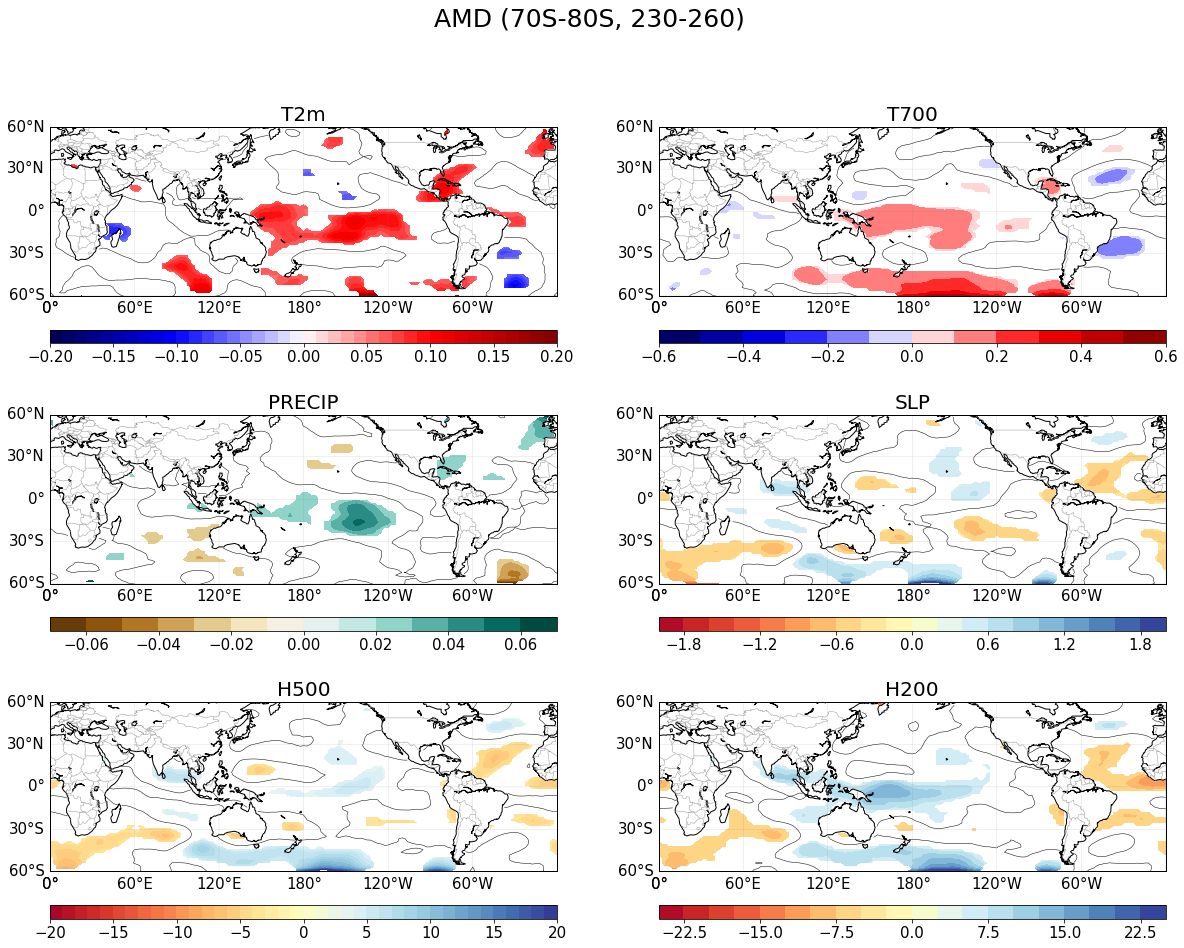

In [13]:
#************************************************
# Plotting GTO maps
#************************************************
plot_region = 'AMD' # Only plot the GTO maps for Amundsen Sea Embayment

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
for i, ax in enumerate(axes.flat):
    ax.set_title(Var[i],size=20)
    m = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=60,\
                llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=180, ax=ax)
    m.drawcoastlines()
    m.drawmapboundary()

    m.drawcountries(color='0.6', linewidth=0.5)
    m.drawparallels(np.arange(-90.,91.,30.),  labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=15)
    m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=15)

    # Make the plot continuous
    K_OLS_cyclic, lons_cyclic           = addcyclic(K_OLS[:,:,GRS.index(plot_region),i], lon)
    K_OLS_mask_cyclic, lons_mask_cyclic = addcyclic(K_OLS_mask[:,:,GRS.index(plot_region),i], lon)

    # Create 2D lat/lon arrays for Basemap
    lon2d, lat2d = np.meshgrid(lons_cyclic, lat)

    # Transforms lat/lon into plotting coordinates for projection
    x, y = m(lon2d, lat2d)

    # Specify colormap range
    if (i ==0):      # T2m
        clevs  = np.linspace(-0.2, 0.2, 41)
        mapp   = plt.cm.seismic
    elif (i ==1):    # T700 
        clevs  = np.linspace(-0.6, 0.6, 13)
        mapp   = plt.cm.seismic        
    elif (i == 2):   # Precip
        clevs  = np.linspace(-0.07, 0.07, 15)
        mapp   = plt.cm.BrBG
    elif (i == 3):   # SLP
        clevs  = np.linspace(-2, 2, 21)
        mapp   = plt.cm.RdYlBu
    elif (i == 4):   # H500
        clevs  = np.linspace(-20, 20, 41)
        mapp   = plt.cm.RdYlBu
    elif (i == 5):   # H200
        clevs  = np.linspace(-25, 25, 21)
        mapp   = plt.cm.RdYlBu

    # Specify zero line
    clevs2  = np.linspace(0, 0, 1)

    # Plot filled-contour plot
    cs      = m.contourf(x, y, K_OLS_mask_cyclic, clevs, cmap=mapp)
    # Plot zero-contour line
    contour = m.contour(x, y, K_OLS_cyclic, clevs2, colors = 'k', linestyles = 'solid', linewidths = 0.5)

    # Plot color bar
    cbar    = m.colorbar(cs, "bottom",size="8%", pad="20%")
    cbar.ax.tick_params(labelsize=15)

plt.suptitle(GR[GRS.index(plot_region)],fontsize=25)

plt.show()
# If you'd like to save GTO maps in a PDF file, please comment out the following line
# plt.savefig('GTO_'+GRS[GRS.index(plot_region)]+'_OLS_merge_test.pdf')

# 4. Results
## 4.1 Interpretation of GTO maps
The above plots show sensitivity of 6 climate variables over AMD to SST changes during austral summer. Through these plots, we know that:
* The $T_{2m}$ and $T700$ are sensitive to tropical western-central Pacific Ocean. The color shading indicates:
  * Red: If $SST$ *increases* over red regions, the climate variable (i.e., $T{2m}$ and $T700$) will *increase*
  * Blue: If $SST$ *increases* over blue regions, the climate variable (i.e., $T{2m}$ and $T700$) will *decrease*
* Increase of $SST$ over tropical central-eastern Pacific can enhance rainfall over AMD during summer time
* While $SLP$ over AMD shows relative noisy response to small-scale patterns of SST changes, the $H500$ and $H200$ shows strong sensitivity to tropical western-central Pacific Ocean.
* $H200$ also shows significant sensitivity to tropical Atlantic ocean

*Note that the black lines denote zero contour line*
